<h1><b>Classification Task</b><h1>   
<h3><li>Importações, Leituras e Definições Iniciais</li><h3>

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning) #Teoricamente será resolvido no próximo patch do xgboost

import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
nh = 3

In [3]:
dados = pd.read_excel('DADOS_MODELAGEM.xlsx')
print(dados.head(nh))

         v1  v2  v3       v4   v5   v6      v7       v8  target
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0


Checagem do tipo dos dados, estrutura do banco, presença de *missings*, análise de consistência, além de uma visão geral sobre a distribuição dos dados. De antemão podemos levantar suspeitas sobre a possibilidade da *feature* v3 ser do tipo categórica, além do fato da distribuição da nossa variável target possuir uma distribuição assimétrica positiva, o que indica que estamos trabalhando com classes desbalanceadas.

In [4]:
print(dados.info())
print(dados.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v1      10000 non-null  float64
 1   v2      10000 non-null  int64  
 2   v3      10000 non-null  int64  
 3   v4      10000 non-null  float64
 4   v5      10000 non-null  float64
 5   v6      10000 non-null  float64
 6   v7      10000 non-null  float64
 7   v8      10000 non-null  float64
 8   target  10000 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 703.2 KB
None
                 v1            v2            v3            v4            v5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.245341     44.225900      1.719500   1775.627776     25.439553   
std        0.449645     13.880531      0.627901    215.729086    126.381291   
min        0.000000      6.000000      1.000000      0.000000      0.000000   
25%        0.000000     33.000000 

Iremos utilizar a função abaixo para avaliar os modelos ajustados nesse estudo. A função possui uma série de medidas que podem, ou não, ser de interesse dependendo da natureza do objetivo da modelagem.

In [5]:
def eval_metrics(orig, pred, model):
    print(model)
    print(f'Accuracy: {accuracy_score(orig, pred)}')
    print(f'Precision: {precision_score(orig, pred)}')
    print(f'Recall: {recall_score(orig, pred)}')
    print(f'F1-Score: {f1_score(orig, pred)}')
    print(f'AUC: {roc_auc_score(orig, pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(orig, pred)}')
    print(classification_report(orig, pred))

Criaremos nosso *benchmark* através de um modelo simples de Regressão Logística para que possamos avaliar a eficiencia dos procedimentos a seguir.

In [6]:
x = dados.drop('target', axis = 1)
y = dados['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

log_model = LogisticRegression()
log_model.fit(x_train, y_train)

y_pred = log_model.predict(x_test)
print(eval_metrics(y_test, y_pred, log_model))

LogisticRegression()
Accuracy: 0.9033333333333333
Precision: 0.75
Recall: 0.2571428571428571
F1-Score: 0.3829787234042553
AUC: 0.622911051212938
Confusion Matrix: 
 [[1310   15]
 [ 130   45]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1325
           1       0.75      0.26      0.38       175

    accuracy                           0.90      1500
   macro avg       0.83      0.62      0.67      1500
weighted avg       0.89      0.90      0.88      1500

None


Como dito da descrição inicial da base, podemos ver através dos resultados anteriores e da frequência abaixo que nossa variável objetivo possui uma proporção de 1:7.7, o que acaba por gerar uma *performance* muito baixa para a classe com menor frequência. Isto fica claro quando analisamos através dos resultados anteriores, que o modelo acerta em mais de 90% dos casos (*Accuracy*), porém, dentre os casos positivos, este possui um acerto de apenas 25.7% (*Recall*), logo, este possui uma *performance* muito alta para casos negativos, mas generaliza muito mal quando se trata de casos positivos.

In [7]:
np.unique(y, return_counts = True)

(array([0, 1], dtype=int64), array([8850, 1150], dtype=int64))

Para resolver o problema das classes desbalanceadas, melhorando a *performance* do modelo nos casos positivos, iremos balancear as classes tornando o número de casos em cada classe equivalentes. Este tipo de estratégia ajuda na generalização do modelo, com o custo de perder acurácia na classe com maior frequência.

In [8]:
dados_samp = pd.concat([dados.loc[dados['target'] == 1, :], dados.loc[dados['target'] == 0, :].sample(frac = (1150 * 1) / 8850)])

x = dados_samp.drop('target', axis = 1)
y = dados_samp['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)
train_index, test_index = x_train.index.tolist(), x_test.index.tolist()

log_model = LogisticRegression(max_iter = 10000)
log_model.fit(x_train, y_train)

print(eval_metrics(y_test, log_model.predict(x_test), 'Test'))

Test
Accuracy: 0.7391304347826086
Precision: 0.7135416666666666
Recall: 0.7965116279069767
F1-Score: 0.7527472527472527
AUC: 0.7392962763812341
Confusion Matrix: 
 [[118  55]
 [ 35 137]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       173
           1       0.71      0.80      0.75       172

    accuracy                           0.74       345
   macro avg       0.74      0.74      0.74       345
weighted avg       0.74      0.74      0.74       345

None


<h3><li>Análises Exploratórias</li><h3>

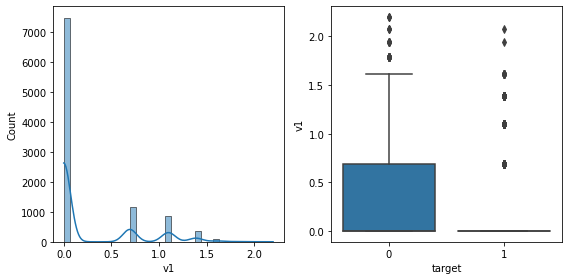

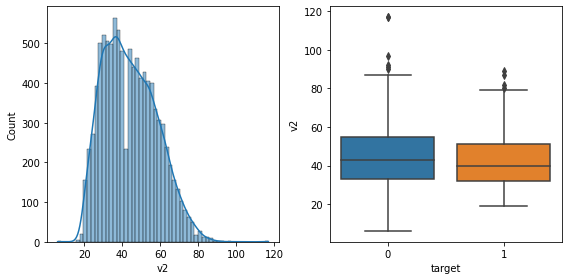

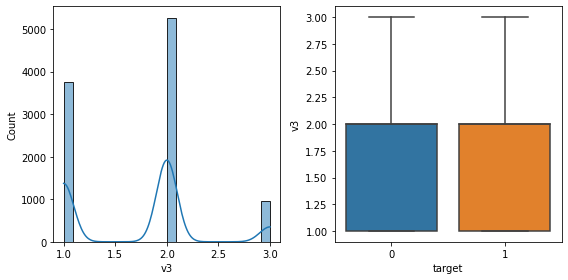

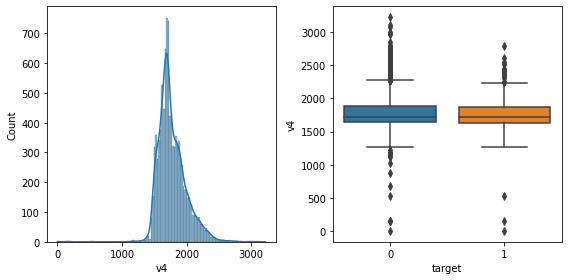

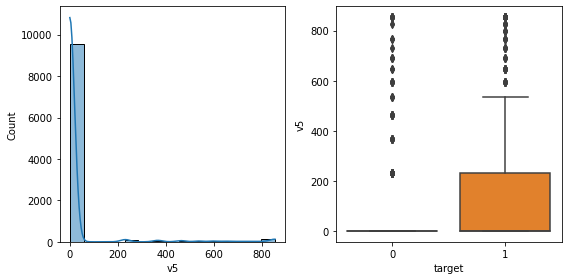

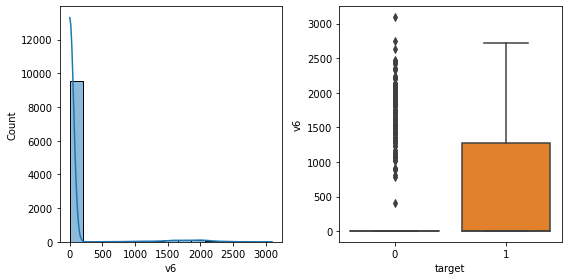

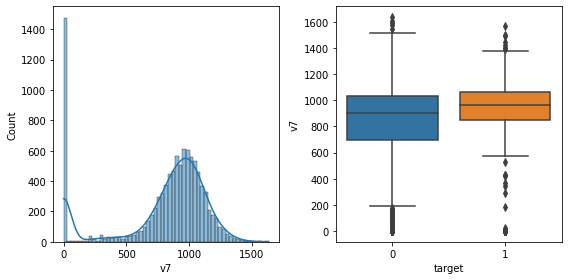

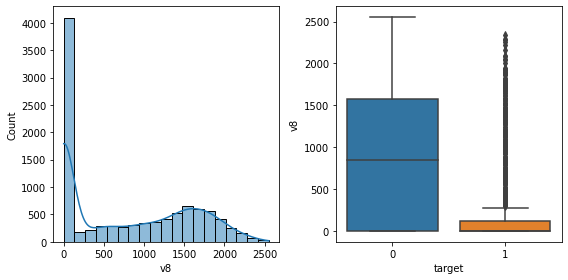

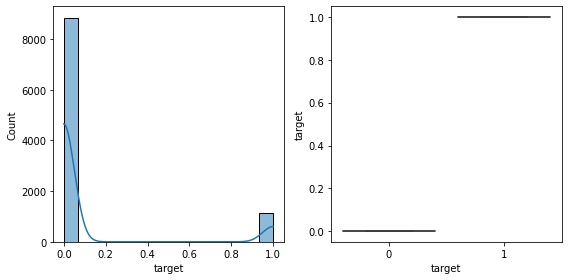

In [9]:
#Análise das distribuições
for i in range(0, len(dados.columns)):
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    sns.histplot(dados[dados.columns[i]], kde = True, ax = ax[0])
    sns.boxplot(x = 'target', y = dados.columns[i], data = dados, ax = ax[1])
    plt.tight_layout()

In [10]:
corr = dados.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,v1,v2,v3,v4,v5,v6,v7,v8,target
v1,1.000000,0.131758,0.180458,0.058310,-0.004342,-0.003332,0.041766,0.008093,-0.026209
v2,0.131758,1.000000,0.424003,0.273066,-0.020909,-0.009825,-0.012039,0.053000,-0.064020
v3,0.180458,0.424003,1.000000,0.135578,-0.029013,-0.022827,0.029944,0.045305,-0.050636
v4,0.058310,0.273066,0.135578,1.000000,-0.003989,0.010579,0.208075,0.107208,-0.040553
v5,-0.004342,-0.020909,-0.029013,-0.003989,1.000000,0.925002,0.069976,-0.135867,0.407386
v6,-0.003332,-0.009825,-0.022827,0.010579,0.925002,1.000000,0.087016,-0.133400,0.415797
v7,0.041766,-0.012039,0.029944,0.208075,0.069976,0.087016,1.000000,-0.110668,0.129682
v8,0.008093,0.053000,0.045305,0.107208,-0.135867,-0.133400,-0.110668,1.000000,-0.252010
target,-0.026209,-0.064020,-0.050636,-0.040553,0.407386,0.415797,0.129682,-0.252010,1.000000


<h3><li>Manipulações e <i>Feature Engineering</i></li><h3>

Nesta parte da análise, tentaremos aplicar algumas estratégias de manipulação com a finalidade de gerar mais informação para a etapa de treino dos modelos. Esta prática nem sempre surte efeitos positivos, porém vale a tentativa.

Supondo que a *feature* v3 seja de natureza categorica, iremos transforma-la em *dummies*.

         v1  v2  v3       v4   v5   v6      v7       v8  target  v3_1  v3_2  \
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0   1.0   0.0   
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0   0.0   1.0   
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0   0.0   1.0   

   v3_3  
0   0.0  
1   0.0  
2   0.0  


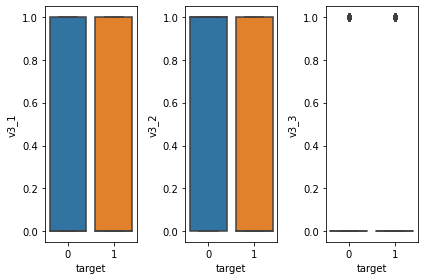

In [11]:
OHE = OneHotEncoder()
dados_cat = pd.DataFrame(OHE.fit_transform(dados[['v3']]).toarray(), columns = ['v3_' + str(i) for i in range(1, 4)])
dados = pd.concat([dados, dados_cat], axis = 1)
print(dados.head(nh))

fig, ax = plt.subplots(1, 3)
sns.boxplot(x = 'target', y = 'v3_1', data = dados, ax = ax[0])
sns.boxplot(x = 'target', y = 'v3_2', data = dados, ax = ax[1])
sns.boxplot(x = 'target', y = 'v3_3', data = dados, ax = ax[2])
plt.tight_layout()

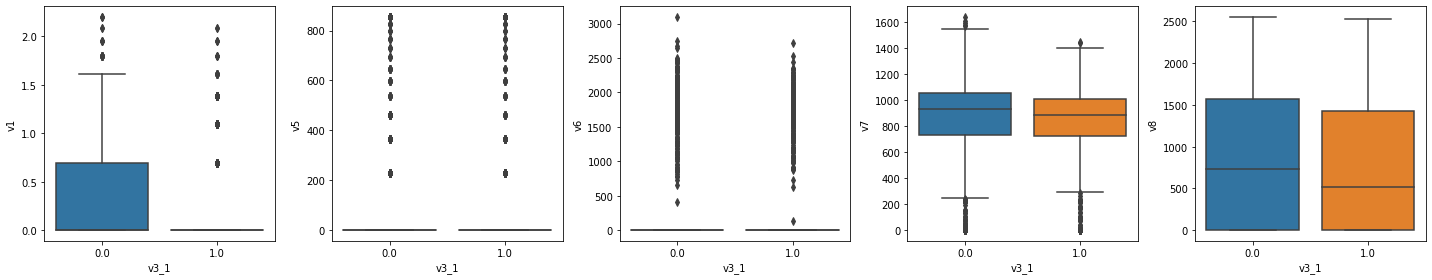

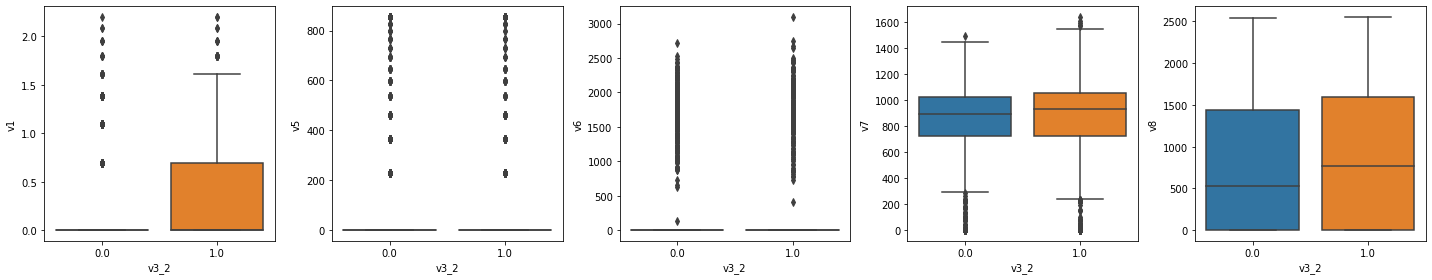

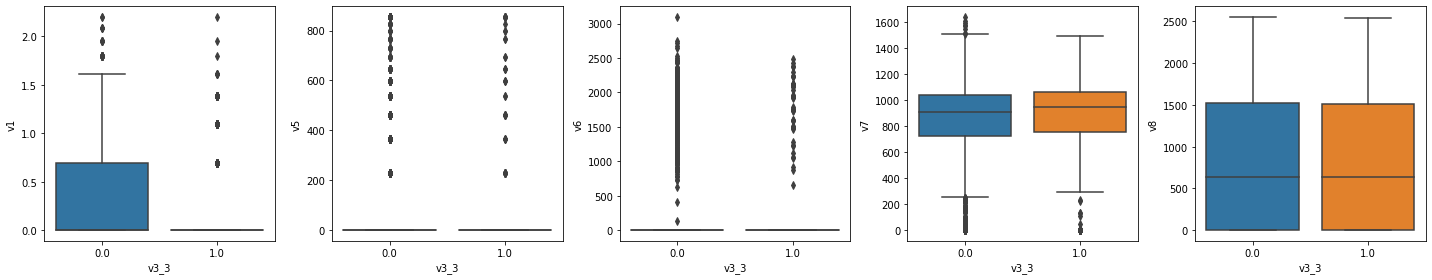

In [12]:
for i in range(1, 4):
    fig, ax = plt.subplots(1, 5, figsize = (20, 4))
    sns.boxplot(x = 'v3_' + str(i), y = 'v1', data = dados, ax = ax[0])
    sns.boxplot(x = 'v3_' + str(i), y = 'v5', data = dados, ax = ax[1])
    sns.boxplot(x = 'v3_' + str(i), y = 'v6', data = dados, ax = ax[2])
    sns.boxplot(x = 'v3_' + str(i), y = 'v7', data = dados, ax = ax[3])
    sns.boxplot(x = 'v3_' + str(i), y = 'v8', data = dados, ax = ax[4])
    plt.tight_layout();

Analisando a distribuição das demais *features* em relação às dummy criadas através da v3, podemos ver que algumas das *features* possuem uma clara relação com alguma(as) da(s) categoria(s) presentes na *feature* original, por conta disto procederemos gerando medidas que reflitam os atributos das classes da v3 original.

In [14]:
agg = dados.groupby('v3')[['v1', 'v7', 'v8', 'v1_flag', 'v2_flag', 'v5_flag', 'v6_flag']].mean().reset_index()
agg.columns = ['v3', 'v1xv3_mean', 'v7xv3_mean', 'v8xv3_mean', 'v1_flagxv3_mean', 'v2_flagxv3_mean', 'v5_flagxv3_mean', 'v6_flagxv3_mean']

dados = dados.merge(agg, on = 'v3', how = 'left')
print(dados.head(nh))

         v1  v2  v3       v4   v5   v6      v7       v8  target  v3_1  v3_2  \
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0   1.0   0.0   
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0   0.0   1.0   
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0   0.0   1.0   

   v3_3  v1_flag  v2_flag  v5_flag  v6_flag  v1xv3_mean  v7xv3_mean  \
0   0.0        1        1        0        0    0.106339  781.280791   
1   0.0        0        1        0        0    0.347372  798.580675   
2   0.0        1        0        0        0    0.347372  798.580675   

   v8xv3_mean  v1_flagxv3_mean  v2_flagxv3_mean  v5_flagxv3_mean  \
0  721.912617         0.112291         0.330236         0.055216   
1  833.677389         0.351926         0.658699         0.039082   
2  833.677389         0.351926         0.658699         0.039082   

   v6_flagxv3_mean  
0         0.055216  
1         0.039082  
2         0.039082  


Criaremos também, algumas medidas indicadoras para algumas variáveis na tentativa de expor padrões inerente às mesmas, e que possivelmente não seriam captados pelos modelos.

In [13]:
dados['v1_flag'] = np.where(dados['v1'] > 0, 1, 0)
dados['v2_flag'] = np.where(dados['v2'] > 40, 1, 0)
dados['v5_flag'] = np.where(dados['v5'] > 0, 1, 0)
dados['v6_flag'] = np.where(dados['v6'] > 0, 1, 0)
print(dados.head(nh))

         v1  v2  v3       v4   v5   v6      v7       v8  target  v3_1  v3_2  \
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0   1.0   0.0   
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0   0.0   1.0   
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0   0.0   1.0   

   v3_3  v1_flag  v2_flag  v5_flag  v6_flag  
0   0.0        1        1        0        0  
1   0.0        0        1        0        0  
2   0.0        1        0        0        0  


A seguir, iremos tentar aplicar uma análise de agrupamento com a finalidade de tentar gerar mais informação através dos dados. Neste caso, optamos por aplicar o algoritmo *KMeans*, que por natureza funciona melhor com dados que possuem suas escalas padronizadas, uma vez que caso isto não se mostre verdade, o algoritmo funcionará de forma a aplicar pesos diferentes às *features*, o que dependendo da situação funciona bem, mas não é nosso objetivo neste estudo.

In [15]:
scale = StandardScaler()
dados_scaled = dados.drop('target', axis = 1)
dados_scaled = scale.fit_transform(dados_scaled)
dados_scaled = pd.DataFrame(dados_scaled, columns = dados.drop('target', axis = 1).columns.tolist())
dados_scaled.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v3_1,v3_2,v3_3,v1_flag,v2_flag,v5_flag,v6_flag,v1xv3_mean,v7xv3_mean,v8xv3_mean,v1_flagxv3_mean,v2_flagxv3_mean,v5_flagxv3_mean,v6_flagxv3_mean
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-5.506706e-18,-1.939782e-16,-6.323830e-17,-1.208278e-15,-8.881784e-18,3.943512e-17,-1.666223e-16,8.526513e-17,-9.450218e-17,-5.044853e-17,1.207923e-17,-2.557954e-17,-1.584510e-16,-2.131628e-18,-2.131628e-18,5.684342e-18,1.634177e-14,2.808065e-15,-6.288303e-17,-1.605827e-16,-8.741452e-16,-8.741452e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-5.456608e-01,-2.754060e+00,-1.145939e+00,-8.231234e+00,-2.013021e-01,-2.128513e-01,-2.095779e+00,-1.011620e+00,-7.774084e-01,-1.055752e+00,-3.262506e-01,-5.793518e-01,-1.117229e+00,-2.190852e-01,-2.190852e-01,-1.229263e+00,-1.116814e+00,-1.199697e+00,-1.237357e+00,-1.216735e+00,-8.883569e-01,-8.883569e-01
25%,-5.456608e-01,-8.087919e-01,-1.145939e+00,-6.535272e-01,-2.013021e-01,-2.128513e-01,-1.783522e-01,-1.011620e+00,-7.774084e-01,-1.055752e+00,-3.262506e-01,-5.793518e-01,-1.117229e+00,-2.190852e-01,-2.190852e-01,-1.229263e+00,-1.116814e+00,-1.199697e+00,-1.237357e+00,-1.216735e+00,-8.883569e-01,-8.883569e-01
50%,-5.456608e-01,-8.832236e-02,4.467491e-01,-2.361542e-01,-2.013021e-01,-2.128513e-01,3.137490e-01,-1.885682e-01,-7.774084e-01,9.471923e-01,-3.262506e-01,-5.793518e-01,8.950714e-01,-2.190852e-01,-2.190852e-01,9.023030e-01,4.064710e-01,9.202733e-01,8.956959e-01,5.597804e-01,-8.883569e-01,-8.883569e-01
75%,9.959598e-01,7.041942e-01,4.467491e-01,5.340053e-01,-2.013021e-01,-2.128513e-01,6.440469e-01,9.553726e-01,1.286325e+00,9.471923e-01,-3.262506e-01,1.726067e+00,8.950714e-01,-2.190852e-01,-2.190852e-01,9.023030e-01,4.064710e-01,9.202733e-01,8.956959e-01,5.597804e-01,1.245132e+00,1.245132e+00
max,4.341161e+00,5.243152e+00,2.039437e+00,6.710521e+00,6.557394e+00,8.100151e+00,2.222141e+00,2.277329e+00,1.286325e+00,9.471923e-01,3.065128e+00,1.726067e+00,8.950714e-01,4.564434e+00,4.564434e+00,9.023030e-01,2.146082e+00,9.202733e-01,8.956959e-01,1.697337e+00,1.245132e+00,1.245132e+00


Para termos uma ideia inicial sobre o número de *clusters* que iremos gerar, aplicaremos o método *Elbow* e analisaremos valores em torno do resultado.

Text(0, 0.5, 'WCSS')

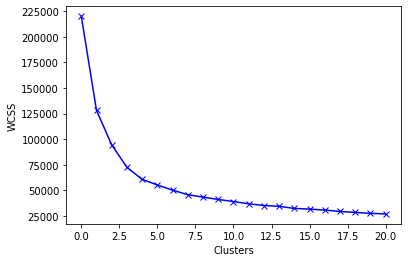

In [16]:
wcss = []
for i in range(1, len(dados_scaled.columns)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(dados_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(wcss, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('WCSS')

Após alguns testes com diferentes números de *clusters*, optaremos por continuar as análises extraindo 5 *clusters* (o mesmo valor assinalado como ótimo pelo método *Elbow*).

In [17]:
nclusters = 5
kmeans = KMeans(n_clusters = nclusters)
kmeans.fit(dados_scaled)
dados_scaled['kmeans_cluster'] = kmeans.labels_
print(np.unique(dados_scaled['kmeans_cluster'], return_counts = True))

(array([0, 1, 2, 3, 4]), array([ 458, 1792, 3559,  918, 3273], dtype=int64))


In [18]:
cluster_centers = pd.DataFrame(scale.inverse_transform(kmeans.cluster_centers_), columns = dados_scaled.columns[0:(dados.shape[1] - 1)])
print(cluster_centers)

             v1         v2        v3           v4            v5            v6  \
0  2.370093e-01  42.879913  1.641921  1768.588603  5.554488e+02  1.730218e+03   
1  9.851234e-01  46.952567  2.000000  1794.244459 -4.263256e-14  4.831691e-13   
2  1.040220e-01  37.105929  1.000000  1733.322003  2.238210e-13  6.536993e-13   
3  2.280041e-01  55.057734  3.000000  1801.121895  6.750156e-14  1.563194e-13   
4 -2.192690e-15  47.625420  2.000000  1805.271983  1.350031e-13  6.252776e-13   

           v7          v8          v3_1          v3_2          v3_3  \
0  917.137642  293.117838  4.541485e-01  4.497817e-01  9.606987e-02   
1  809.370257  871.564833  1.276756e-15  1.000000e+00 -5.273559e-16   
2  774.751821  748.828131  1.000000e+00  4.329870e-15 -8.881784e-16   
3  814.276895  784.194270 -1.831868e-15  1.998401e-15  1.000000e+00   
4  783.487797  846.484635  5.495604e-15  1.000000e+00 -8.604228e-16   

        v1_flag   v2_flag       v5_flag       v6_flag  v1xv3_mean  v7xv3_mean  \
0  2.

kmeans_cluster         0         1         2         3         4
target                                                          
0               0.013898  0.190056  0.361130  0.095254  0.339661
1               0.291304  0.095652  0.315652  0.065217  0.232174


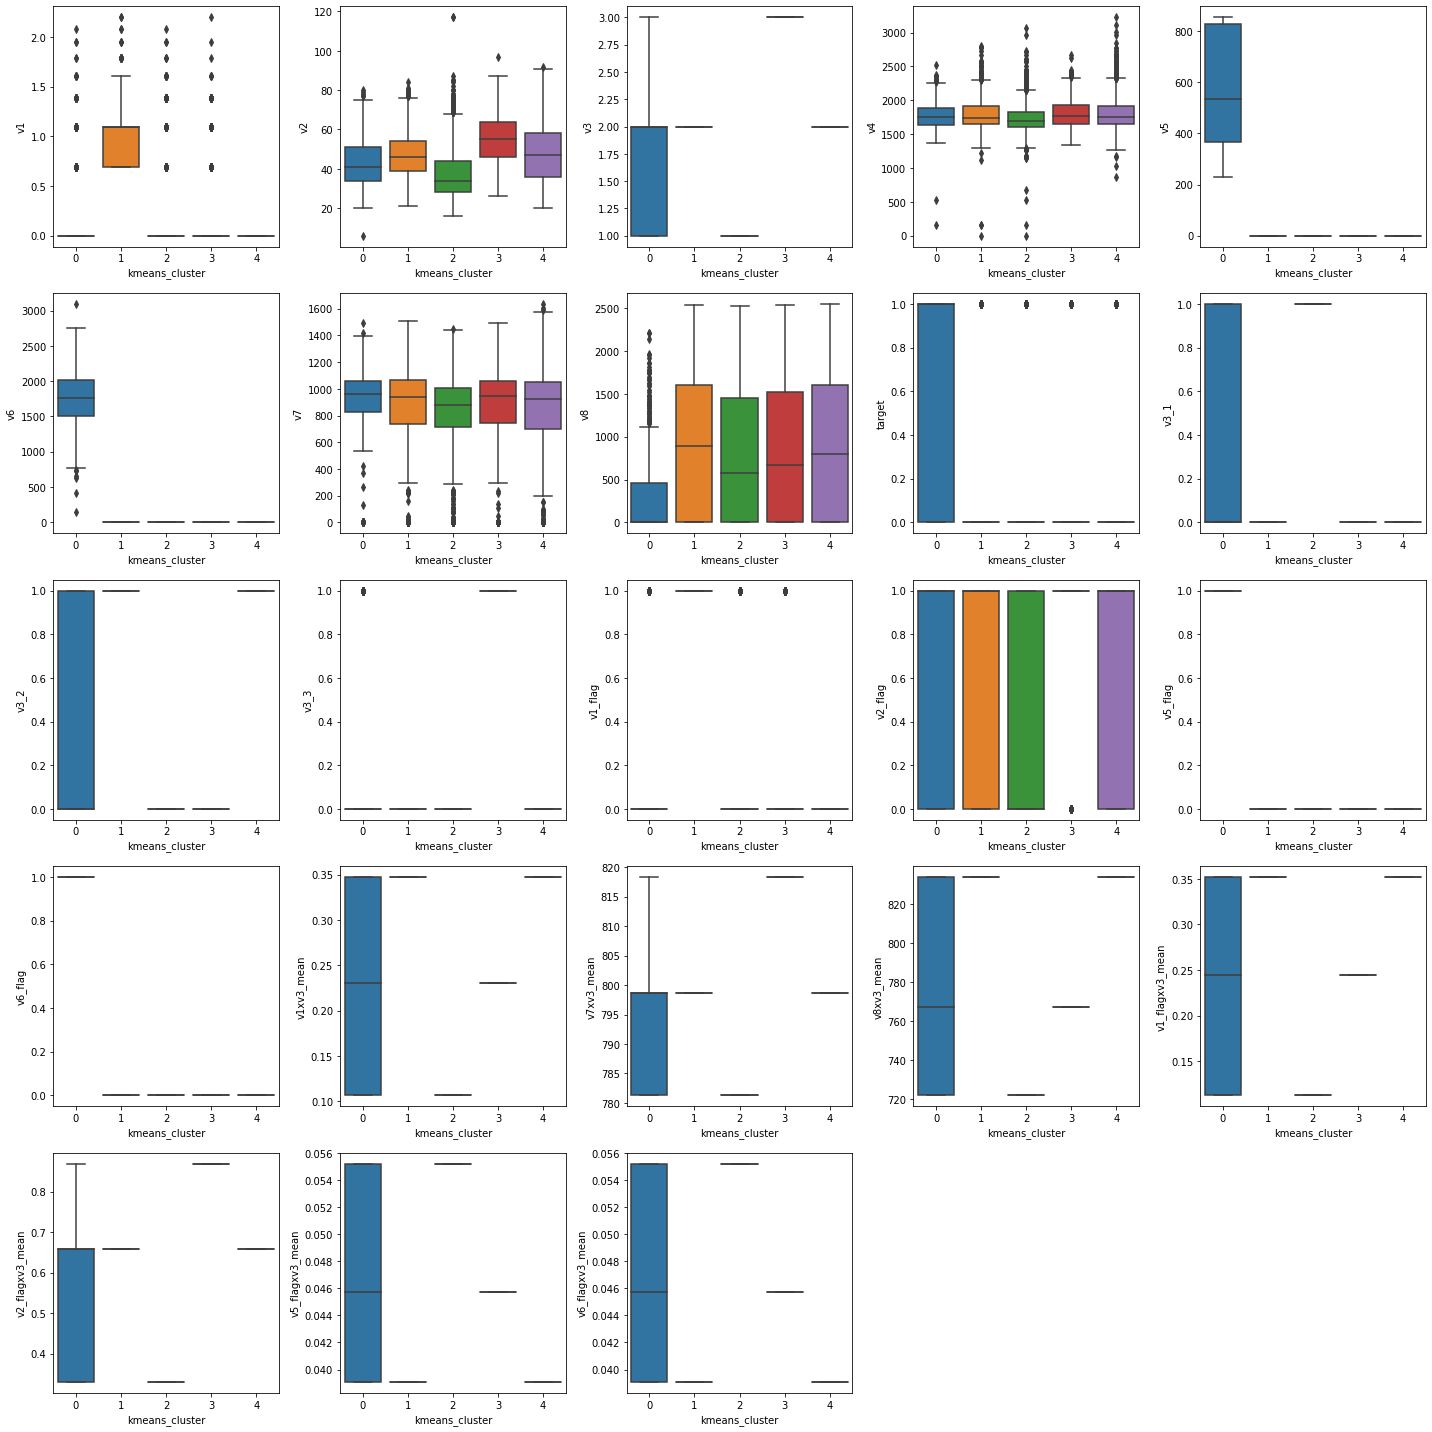

In [19]:
dados['kmeans_cluster'] = kmeans.labels_
plt.figure(figsize = (20, 20))
for i in range(0, len(dados.columns) - 1):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x = 'kmeans_cluster', y = dados.columns[i], data = dados)
plt.tight_layout();

print(pd.crosstab(dados['target'], dados['kmeans_cluster'], normalize = 'index'))

Assim como fizemos anteriormente com a *feature* v3, iremos tentar extrair padrões mais "profundos" dos dados gerando medidas que reflitam as características dos grupos presentes na *feature* de *clusters*.

In [20]:
agg = dados.groupby('kmeans_cluster')[['v1', 'v7', 'v8', 'v1_flag', 'v2_flag', 'v5_flag', 'v6_flag']].mean().reset_index()
agg.columns = ['kmeans_cluster', 'v1xclust_mean', 'v7xclust_mean', 'v8xclust_mean', 'v1_flagxclust_mean', 'v2_flagxclust_mean', 'v5_flagxclust_mean', 'v6_flagxclust_mean']

dados = dados.merge(agg, on = 'kmeans_cluster', how = 'left')
print(dados.head(nh))

         v1  v2  v3       v4   v5   v6      v7       v8  target  v3_1  v3_2  \
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0   1.0   0.0   
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0   0.0   1.0   
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0   0.0   1.0   

   v3_3  v1_flag  v2_flag  v5_flag  v6_flag  v1xv3_mean  v7xv3_mean  \
0   0.0        1        1        0        0    0.106339  781.280791   
1   0.0        0        1        0        0    0.347372  798.580675   
2   0.0        1        0        0        0    0.347372  798.580675   

   v8xv3_mean  v1_flagxv3_mean  v2_flagxv3_mean  v5_flagxv3_mean  \
0  721.912617         0.112291         0.330236         0.055216   
1  833.677389         0.351926         0.658699         0.039082   
2  833.677389         0.351926         0.658699         0.039082   

   v6_flagxv3_mean  kmeans_cluster  v1xclust_mean  v7xclust_mean  \
0         0.055216               2       0.104022     774

Por fim, geraremos novas *features* que reflitam o limite observado de alguns campos, uma vez que estas informações podem, dependendo dos padrões captados, apresentar algum poder preditivo em relação à nossa variável *target*.

In [21]:
dados['v2_flag_cutE20'] = np.where(dados['v2'] <= 20, 1, 0)
dados['v2_flag_80cutE'] = np.where(dados['v2'] >= 80, 1, 0)
dados['v7_flag_cutE600'] = np.where(dados['v7'] <= 600, 1, 0)
dados['v7_flag_1400cutE'] = np.where(dados['v7'] >= 1400, 1, 0)
dados['v8_flag_250cutE'] = np.where(dados['v8'] >= 250, 1, 0)
print(dados.head(nh))

         v1  v2  v3       v4   v5   v6      v7       v8  target  v3_1  v3_2  \
0  1.098612  50   1  1724.61  0.0  0.0  729.07   765.69       0   1.0   0.0   
1  0.000000  41   2  2198.59  0.0  0.0    0.00     0.00       0   0.0   1.0   
2  1.098612  39   2  1633.05  0.0  0.0  915.17  1108.55       0   0.0   1.0   

   v3_3  v1_flag  v2_flag  v5_flag  v6_flag  v1xv3_mean  v7xv3_mean  \
0   0.0        1        1        0        0    0.106339  781.280791   
1   0.0        0        1        0        0    0.347372  798.580675   
2   0.0        1        0        0        0    0.347372  798.580675   

   v8xv3_mean  v1_flagxv3_mean  v2_flagxv3_mean  v5_flagxv3_mean  \
0  721.912617         0.112291         0.330236         0.055216   
1  833.677389         0.351926         0.658699         0.039082   
2  833.677389         0.351926         0.658699         0.039082   

   v6_flagxv3_mean  kmeans_cluster  v1xclust_mean  v7xclust_mean  \
0         0.055216               2       0.104022     774

In [22]:
print(dados.describe())

corr = dados.corr()
corr.style.background_gradient(cmap = 'coolwarm')

                 v1            v2            v3            v4            v5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.245341     44.225900      1.719500   1775.627776     25.439553   
std        0.449645     13.880531      0.627901    215.729086    126.381291   
min        0.000000      6.000000      1.000000      0.000000      0.000000   
25%        0.000000     33.000000      1.000000   1634.650000      0.000000   
50%        0.000000     43.000000      2.000000   1724.685000      0.000000   
75%        0.693147     54.000000      2.000000   1890.822500      0.000000   
max        2.197225    117.000000      3.000000   3223.210000    854.130000   

                 v6            v7            v8        target          v3_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      79.244001    793.964402    785.160602      0.115000      0.376700   
std      372.316123    378.858728    776.180405    

,v1,v2,v3,v4,v5,v6,v7,v8,target,v3_1,v3_2,v3_3,v1_flag,v2_flag,v5_flag,v6_flag,v1xv3_mean,v7xv3_mean,v8xv3_mean,v1_flagxv3_mean,v2_flagxv3_mean,v5_flagxv3_mean,v6_flagxv3_mean,kmeans_cluster,v1xclust_mean,v7xclust_mean,v8xclust_mean,v1_flagxclust_mean,v2_flagxclust_mean,v5_flagxclust_mean,v6_flagxclust_mean,v2_flag_cutE20,v2_flag_80cutE,v7_flag_cutE600,v7_flag_1400cutE,v8_flag_250cutE
v1,1.000000,0.131758,0.180458,0.058310,-0.004342,-0.003332,0.041766,0.008093,-0.026209,-0.240338,0.239576,-0.010696,0.941847,0.167567,-0.004060,-0.004060,0.251494,0.171912,0.250876,0.251433,0.203301,-0.251237,-0.251237,-0.527388,0.786056,0.273153,0.159931,0.785957,0.262028,-0.004060,-0.004060,-0.050368,-0.014180,-0.014554,0.006094,0.002785
v2,0.131758,1.000000,0.424003,0.273066,-0.020909,-0.009825,-0.012039,0.053000,-0.064020,-0.397213,0.237806,0.250097,0.105993,0.811741,-0.021246,-0.021246,0.334115,0.421479,0.314760,0.339896,0.425821,-0.345732,-0.345732,0.165867,0.087629,0.134138,0.140563,0.087447,0.416584,-0.021246,-0.021246,-0.170072,0.238163,0.072911,0.040046,-0.003406
v3,0.180458,0.424003,1.000000,0.135578,-0.029013,-0.022827,0.029944,0.045305,-0.050636,-0.890863,0.471656,0.665368,0.189795,0.368359,-0.027070,-0.027070,0.717542,0.998866,0.666979,0.732802,0.990060,-0.748291,-0.748291,0.331432,0.220095,0.346663,0.280214,0.220402,0.962466,-0.027070,-0.027070,-0.105833,0.054408,0.013911,0.027778,0.011145
v4,0.058310,0.273066,0.135578,1.000000,-0.003989,0.010579,0.208075,0.107208,-0.040553,-0.152457,0.125431,0.038157,0.039274,0.230444,-0.007149,-0.007149,0.145850,0.132104,0.142381,0.146798,0.144038,-0.147708,-0.147708,0.071242,0.028560,0.037273,0.061883,0.027940,0.138699,-0.007149,-0.007149,-0.098037,0.010561,-0.074819,0.141816,0.014755
v5,-0.004342,-0.020909,-0.029013,-0.003989,1.000000,0.925002,0.069976,-0.135867,0.407386,0.037438,-0.036184,-0.000256,-0.014532,-0.015224,0.918830,0.918830,-0.038590,-0.027765,-0.038363,-0.038623,-0.032314,0.038637,0.038637,-0.401942,-0.004746,0.807624,-0.833346,-0.016079,-0.039417,0.918830,0.918830,-0.010316,-0.009274,-0.074133,-0.002732,-0.129761
v6,-0.003332,-0.009825,-0.022827,0.010579,0.925002,1.000000,0.087016,-0.133400,0.415797,0.030341,-0.030188,0.001254,-0.013588,-0.003866,0.971546,0.971546,-0.031721,-0.021752,-0.031636,-0.031715,-0.025698,0.031692,0.031692,-0.425002,-0.005018,0.853959,-0.881157,-0.017001,-0.041678,0.971546,0.971546,-0.009185,-0.010541,-0.079104,0.009315,-0.124382
v7,0.041766,-0.012039,0.029944,0.208075,0.069976,0.087016,1.000000,-0.110668,0.129682,-0.026028,0.012865,0.020990,0.034061,0.013786,0.071232,0.071232,0.020492,0.029978,0.018909,0.020972,0.029446,-0.021460,-0.021460,-0.040529,0.028161,0.081040,-0.055541,0.027352,0.028998,0.071232,0.071232,-0.029566,-0.047218,-0.903033,0.100151,-0.133523
v8,0.008093,0.053000,0.045305,0.107208,-0.135867,-0.133400,-0.110668,1.000000,-0.252010,-0.063351,0.065995,-0.007637,0.009483,0.025735,-0.138891,-0.138891,0.067759,0.042844,0.067926,0.067637,0.051973,-0.067474,-0.067474,0.072370,0.031158,-0.104954,0.153139,0.032409,0.053194,-0.138891,-0.138891,-0.010291,-0.001983,0.127453,0.028287,0.858303
target,-0.026209,-0.064020,-0.050636,-0.040553,0.407386,0.415797,0.129682,-0.252010,1.000000,0.060675,-0.054098,-0.008111,-0.036129,-0.042564,0.423335,0.423335,-0.060200,-0.048946,-0.059304,-0.060422,-0.054952,0.060621,0.060621,-0.181510,-0.035051,0.354385,-0.401438,-0.040087,-0.054709,0.423335,0.423335,0.015434,-0.014570,-0.131203,0.008091,-0.254982
v3_1,-0.240338,-0.397213,-0.890863,-0.152457,0.037438,0.030341,-0.026028,-0.063351,0.060675,1.000000,-0.820750,-0.253630,-0.249139,-0.351929,0.035017,0.035017,-0.955639,-0.868221,-0.932654,-0.961932,-0.945900,0.967976,0.967976,-0.367456,-0.294697,-0.287416,-0.402220,-0.290747,-0.917739,0.035017,0.035017,0.118214,-0.039214,-0.023818,-0.035927,-0.022813


<h3><li>Treino e Validação</li><h3>

Uma vez que os dados foram devidamente preparados, partiremos para a estimação dos parâmetros dos modelos.
    
Neste estudo preliminar, iremos manter todas as *features* geradas até o momento, além de não definir de forma fidedigna os bancos de validação e de teste, uma vez que nossa classe positiva possui uma frequência bem limitada. Em um estudo mais coerente, estas bases deveriam ser metodicamente definidas, além de através de análises iniciais remover *features* que se mostrassem não necessárias para o treino dos modelos.
    
Após algumas análises iniciais optamos por padronizar a escala dos dados, uma vez que esse procedimento se mostrou eficáz para melhorar a *performance* dos modelos, além de ajudar alguns processos de estimação a obter a convergência mais rápido.

In [53]:
scale = StandardScaler()
dados_scaled = dados.drop('target', axis = 1)
dados_scaled = scale.fit_transform(dados_scaled)
dados_scaled = pd.DataFrame(dados_scaled, columns = dados.drop('target', axis = 1).columns.tolist())
print(dados_scaled.describe())

x_train, x_test = dados_scaled.iloc[train_index, :], dados_scaled.iloc[test_index, :]
y_train, y_test = dados['target'].iloc[train_index], dados['target'].iloc[test_index]

                 v1            v2            v3            v4            v5  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean  -5.506706e-18 -1.939782e-16 -6.323830e-17 -1.208278e-15 -8.881784e-18   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -5.456608e-01 -2.754060e+00 -1.145939e+00 -8.231234e+00 -2.013021e-01   
25%   -5.456608e-01 -8.087919e-01 -1.145939e+00 -6.535272e-01 -2.013021e-01   
50%   -5.456608e-01 -8.832236e-02  4.467491e-01 -2.361542e-01 -2.013021e-01   
75%    9.959598e-01  7.041942e-01  4.467491e-01  5.340053e-01 -2.013021e-01   
max    4.341161e+00  5.243152e+00  2.039437e+00  6.710521e+00  6.557394e+00   

                 v6            v7            v8          v3_1          v3_2  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean   3.943512e-17 -1.666223e-16  8.526513e-17 -9.450218e-17 -5.044853e-17   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.

Treinando novamente o modelo incial de Regressão Logística, porém, agora com as *features* geradas durante o processo de análise.

In [25]:
log_model = LogisticRegression(max_iter = 10000)
log_model.fit(x_train, y_train)

print(eval_metrics(y_train, log_model.predict(x_train), 'Train'))
print(eval_metrics(y_test, log_model.predict(x_test), 'Test'))

Train
Accuracy: 0.7432225063938619
Precision: 0.7253787878787878
Recall: 0.7832310838445807
F1-Score: 0.7531956735496559
AUC: 0.7432020311751052
Confusion Matrix: 
 [[687 290]
 [212 766]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       977
           1       0.73      0.78      0.75       978

    accuracy                           0.74      1955
   macro avg       0.74      0.74      0.74      1955
weighted avg       0.74      0.74      0.74      1955

None
Test
Accuracy: 0.7478260869565218
Precision: 0.7374301675977654
Recall: 0.7674418604651163
F1-Score: 0.7521367521367522
AUC: 0.7478827799435408
Confusion Matrix: 
 [[126  47]
 [ 40 132]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       173
           1       0.74      0.77      0.75       172

    accuracy                           0.75       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.

Dentre os diversos métodos de seleção de *features*, testaremos brevemente o *Recursive Feature Elimination*, que de forma resumida, segue removendo *features* que apresentem um grau de imporância menor, até que o critério de parada seja satisfeito.

In [26]:
rfe_subset = RFE(estimator = LogisticRegression(max_iter = 10000), n_features_to_select = 15, step = 1)
rfe_subset.fit(x_train, y_train)
rfe_cols = x_train.columns[rfe_subset.get_support()]

rfe_model = LogisticRegression(max_iter = 10000)
rfe_model.fit(x_train[rfe_cols], y_train)

print(eval_metrics(y_test, rfe_model.predict(x_test[rfe_cols]), 'Test'))

Test
Accuracy: 0.7536231884057971
Precision: 0.7403314917127072
Recall: 0.7790697674418605
F1-Score: 0.7592067988668556
AUC: 0.7536967334319129
Confusion Matrix: 
 [[126  47]
 [ 38 134]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       173
           1       0.74      0.78      0.76       172

    accuracy                           0.75       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.75      0.75      0.75       345

None


Por fim, treinaremos um XGBoost, uma implementação do Grandient Boosting baseada em Decision Trees.

In [27]:
data_dmatrix = xgb.DMatrix(data = x_train, label = y_train)
xgb_model = xgb.XGBRegressor(objective = 'reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100)
xgb_model.fit(x_train, y_train)

print(eval_metrics(y_train, np.where(xgb_model.predict(x_train) > 0.5, 1, 0), 'Train'))
print(eval_metrics(y_test, np.where(xgb_model.predict(x_test) > 0.5, 1, 0), 'Test'))

Train
Accuracy: 0.769309462915601
Precision: 0.7648241206030151
Recall: 0.778118609406953
F1-Score: 0.7714140902179422
AUC: 0.7693049546522994
Confusion Matrix: 
 [[743 234]
 [217 761]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       977
           1       0.76      0.78      0.77       978

    accuracy                           0.77      1955
   macro avg       0.77      0.77      0.77      1955
weighted avg       0.77      0.77      0.77      1955

None
Test
Accuracy: 0.7536231884057971
Precision: 0.7457627118644068
Recall: 0.7674418604651163
F1-Score: 0.7564469914040115
AUC: 0.7536631267643501
Confusion Matrix: 
 [[128  45]
 [ 40 132]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       173
           1       0.75      0.77      0.76       172

    accuracy                           0.75       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.75

Treinados os principais modelos, podemos tentar aplicar o método de *Ensemble* para checar um possível aprimoramento na performance da solução.

In [28]:
ensb_pred = np.where(
    np.mean(
        np.array(
            [log_model.predict(x_test), 
             rfe_model.predict(x_test[rfe_cols]), 
             np.where(xgb_model.predict(x_test) > 0.5, 1, 0)]), 
        axis = 0) > 0.5, 1, 0)

print(eval_metrics(y_test, ensb_pred, 'Test'))

Test
Accuracy: 0.7507246376811594
Precision: 0.7415730337078652
Recall: 0.7674418604651163
F1-Score: 0.7542857142857143
AUC: 0.7507729533539454
Confusion Matrix: 
 [[127  46]
 [ 40 132]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       173
           1       0.74      0.77      0.75       172

    accuracy                           0.75       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.75      0.75      0.75       345

None


Uma vez que não obtivemos grandes avanços nas estratégias adotadas até o momento, seguiremos em busca do modelo mais parcimonioso, isto é, o modelo mais performático, e de menor complexidade. Abaixo podemos analisar a mensuração da importância das *features* gerada pelo XGBoost, e posteriormente aplicar essa informação para checar quais *features* justificam sua permanência na solução.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

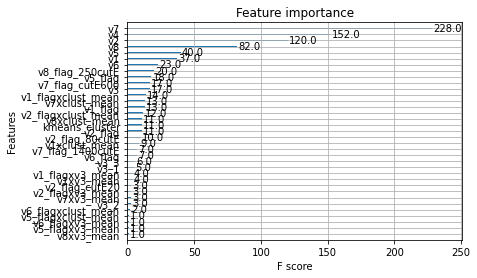

In [29]:
plot_importance(xgb_model)

In [ ]:
x_train = x_train.assign(
    ensb_pred = np.where(
        np.mean(
            np.array(
                [log_model.predict(x_train), 
                 rfe_model.predict(x_train[rfe_cols]), 
                 np.where(xgb_model.predict(x_train) > 0.5, 1, 0)]), 
            axis = 0) > 0.5, 1, 0))

x_test = x_test.assign(
    ensb_pred = np.where(
        np.mean(
            np.array(
                [log_model.predict(x_test), 
                 rfe_model.predict(x_test[rfe_cols]), 
                 np.where(xgb_model.predict(x_test) > 0.5, 1, 0)]), 
            axis = 0) > 0.5, 1, 0))

In [38]:
fit_cols = ['v2', 'v4', 'v5', 'v6', 'v7', 'v8', 'v8_flag_250cutE', 'v1_flag', 'ensb_pred']
compact_model = LogisticRegression(max_iter = 10000)
compact_model.fit(x_train[fit_cols], y_train)

print(eval_metrics(y_test, compact_model.predict(x_test[fit_cols]), 'Test'))

Test
Accuracy: 0.7420289855072464
Precision: 0.7292817679558011
Recall: 0.7674418604651163
F1-Score: 0.7478753541076487
AUC: 0.7421024331227315
Confusion Matrix: 
 [[124  49]
 [ 40 132]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       173
           1       0.73      0.77      0.75       172

    accuracy                           0.74       345
   macro avg       0.74      0.74      0.74       345
weighted avg       0.74      0.74      0.74       345

None


Antes de finalizarmos a análise, iremos checar se o algorítmo de Stepwise aplicando a F1-Score retorna uma solução melhor do que a encontrada até o momento.

In [48]:
forward_feats = LogisticRegression(max_iter = 10000)
forward_feats = SequentialFeatureSelector(forward_feats, n_features_to_select = 10, direction = 'forward', scoring = 'f1')
forward_feats.fit(x_train, y_train)

forward_model = LogisticRegression(max_iter = 10000)
forward_model.fit(forward_feats.transform(x_train), y_train)

print(eval_metrics(y_test, forward_model.predict(forward_feats.transform(x_test)), 'Test'))

Test
Accuracy: 0.7507246376811594
Precision: 0.7415730337078652
Recall: 0.7674418604651163
F1-Score: 0.7542857142857143
AUC: 0.7507729533539454
Confusion Matrix: 
 [[127  46]
 [ 40 132]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       173
           1       0.74      0.77      0.75       172

    accuracy                           0.75       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.75      0.75      0.75       345

None


Após analisarmos os resultados obtidos até o momento, podemos notar que pouca informação pôde ser aproveitada da etapa de *Feature Engeneering*. Análises mais profundas podem nos conduzir à soluções que apresentem uma melhor *performance*, porém, para este primeiro estudo optaremos por um modelo mais simples, e que demonstrou um melhor poder de generalização quando comparado com nossa solução inicial. Optamos por remover as *features* v1, e v3, além de incluir outras duas que foram geradas durante as etapadas anteriores.

Nossa solução final apresentou boas medidas de desempenho, porém, ainda sim mostra uma *performance* diferente quando comparamos seu desempenho entre as classes, este problema pode ser contornado otimizando os dados e os parâmetros de treino. Por fim, algo a ser levado em consideração é o fato de que por possuírmos uma amostra pequena, os modelos se mostraram muito sensíveis às amostras, uma vez que o pequeno número de casos implica em uma grande variação amostral, o que torna os resultados instáveis.

In [54]:
fit_cols = ['v2', 'v4', 'v5', 'v6', 'v7', 'v8', 'v8_flag_250cutE', 'v1_flag']

compact_model = LogisticRegression(max_iter = 10000)
compact_model.fit(x_train[fit_cols], y_train)

print(eval_metrics(y_test, compact_model.predict(x_test[fit_cols]), 'Test'))

Test
Accuracy: 0.7594202898550725
Precision: 0.7329842931937173
Recall: 0.813953488372093
F1-Score: 0.7713498622589532
AUC: 0.7595779002554107
Confusion Matrix: 
 [[122  51]
 [ 32 140]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       173
           1       0.73      0.81      0.77       172

    accuracy                           0.76       345
   macro avg       0.76      0.76      0.76       345
weighted avg       0.76      0.76      0.76       345

None
